In [1]:
#导入transformers
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

# 导入torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


# 常用包
import re
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data = pd.read_csv('shuju2.csv')

In [3]:
data

,留言编号,留言用户,留言主题,留言时间,留言详情,一级标签
0,24,A00074011,A市西湖建筑集团占道施工有安全隐患,2020/1/612:09:38,A3区大道西行便道，未管所路口至加油站路段，人行道包括路灯杆，被圈西湖建筑集团燕子山安置房项...,城乡建设
1,37,U0008473,A市在水一方大厦人为烂尾多年，安全隐患严重,2020/1/411:17:46,位于书院路主干道的在水一方大厦一楼至四楼人为拆除水、电等设施后，烂尾多年，用护栏围着，不但占...,城乡建设
2,83,A00063999,投诉A市A1区苑物业违规收停车费,2019/12/3017:06:14,尊敬的领导：A1区苑小区位于A1区火炬路，小区物业A市程明物业管理有限公司，未经小区业主同意...,城乡建设
3,303,U0007137,A1区蔡锷南路A2区华庭楼顶水箱长年不洗,2019/12/614:40:14,A1区A2区华庭小区高层为二次供水，楼顶水箱长年不洗，现在自来水龙头的水严重霉味，大家都知道...,城乡建设
4,319,U0007137,A1区A2区华庭自来水好大一股霉味,2019/12/511:17:22,A1区A2区华庭小区高层为二次供水，楼顶水箱长年不洗，现在自来水龙头的水严重霉味，大家都知道...,城乡建设
...,...,...,...,...,...,...
9205,11763690,U0005980,两孩子一个是一级脑瘫，能再生育吗？,2015/4/2218:46:00,我们夫妻都是农村户口，大的是女9岁，小的是儿2岁半，才15斤，治疗两年，一级脑瘫。我是纯女户...,卫生计生
9206,11977590,U0005367,B市中心医院医生不负责任，做无痛人流手术后结果还是活胚芽,2014/9/2915:16:46,本人2015年2月16号在B市中心医院做无痛人流手术，手术后还有怀孕的症状，于2015年2月...,卫生计生
9207,14697490,U0002040,西地省二胎产假新政策何时出台？,2016/2/2915:17:44,我们是再婚，很想再要一个小孩，不知我省二胎新政策何时出，如果先怀孕了，会做和处理,卫生计生
9208,15397690,U0001803,K8县惊现奇葩证明！,2016/4/178:15:17,K8县惊现奇葩证明！我是西地省K8县人，想生二孩。被告知要开证明，即“没生二孩的证明”。先写...,卫生计生


In [4]:
data['留言内容'] = data['留言主题'] + ' ' + data['留言详情']

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9210 entries, 0 to 9209
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   留言编号    9210 non-null   int64 
 1   留言用户    9210 non-null   object
 2   留言主题    9210 non-null   object
 3   留言时间    9210 non-null   object
 4   留言详情    9210 non-null   object
 5   一级标签    9210 non-null   object
 6   留言内容    9210 non-null   object
dtypes: int64(1), object(6)
memory usage: 503.8+ KB


## 标签分布

In [6]:
data['一级标签'].value_counts()

一级标签
城乡建设       2009
劳动和社会保障    1969
教育文体       1589
商贸旅游       1215
环境保护        938
卫生计生        877
交通运输        613
Name: count, dtype: int64

In [7]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [8]:
# 选择要保留的列
columns_to_keep = ['留言内容', '一级标签']

# 对分类的类别做映射
unique_values = data['一级标签'].unique()

# 创建映射关系字典
mapping_dict = {value: index for index, value in enumerate(unique_values)}

# 将列中的值替换为映射后的值
data['一级标签'] = data['一级标签'].map(mapping_dict)
data_new = data[columns_to_keep]

# 划分数据集
train, test = train_test_split(data_new, test_size=0.2, stratify=data_new['一级标签'], random_state=42)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7368 entries, 340 to 557
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   留言内容    7368 non-null   object
 1   一级标签    7368 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 172.7+ KB


In [10]:
train['一级标签']

340     0
6256    4
3622    3
6725    4
7215    5
       ..
5190    4
8999    6
8529    6
4415    3
557     0
Name: 一级标签, Length: 7368, dtype: int64

In [11]:
train

,留言内容,一级标签
340,咨询A3区西湖街道茶场村的规划问题 我是A3区西湖街道茶场村五组的村民。我们这个A3区山下名...,0
6256,请及时发放2015年监理工程师执业资格证 贺厅长:您好！我是马高飞，2015年通过了全国监理...,4
3622,A7县蒿塘中学的安全要如何保障？ 在2011年10月30日凌晨2:20分，A7县蒿塘中学的老...,3
6725,咨询L4县失业人员的社保补贴问题 我妻子失业后随我迁入L1区居住，戸口也迁入了L1区城北居委...,4
7215,建议开发A6区县洪山村洪山古庵为旅游景点 洪山村洪山古庵历史怒久，文化底蕴好，周边环境优美，...,5
...,...,...
5190,养老保险一次性要交近4万我们这些小职工如何承受 彭厅长：你好！我是一名集体单位的职工，92年...,4
8999,希望K市三医院办理特殊门诊的窗口可以增加 每天到K市三医院办理特殊门诊的患者有很多，明明有两...,6
8529,E7县鸭田镇计生办人员强行关押超生困难群众 2013年1月9日E7县鸭田镇计生办工作人员强行...,6
4415,揭露M3县十四中教育乱象 在国家三令五申减轻学生负担，不准乱收费，不准补课情况下，M3县十四...,3


In [12]:
element_counts = Counter(train['一级标签'])
# 统计每个类别的样本数
pinlv = [0,0,0,0,0,0,0]
for element, count in element_counts.items():
    pinlv[element] = count

<BarContainer object of 7 artists>

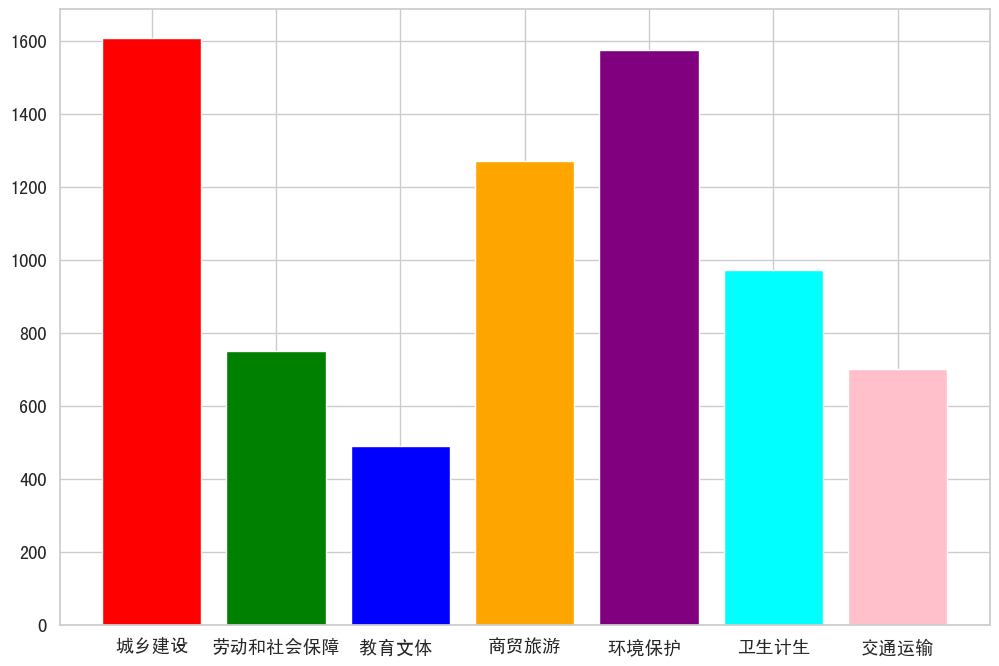

In [13]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为中文宋体
plt.rcParams['axes.unicode_minus'] = False
plt.bar(['城乡建设','劳动和社会保障','教育文体 ','商贸旅游','环境保护 ','卫生计生','交通运输'], pinlv, color=['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'pink'])

### 文本长度分布

In [14]:
train['文本长度']=train['留言内容'].map(len)
train['文本长度'].describe()

count    7368.000000
mean      415.183903
std       491.025698
min        23.000000
25%       135.000000
50%       236.000000
75%       481.000000
max      6125.000000
Name: 文本长度, dtype: float64

<Axes: ylabel='Density'>

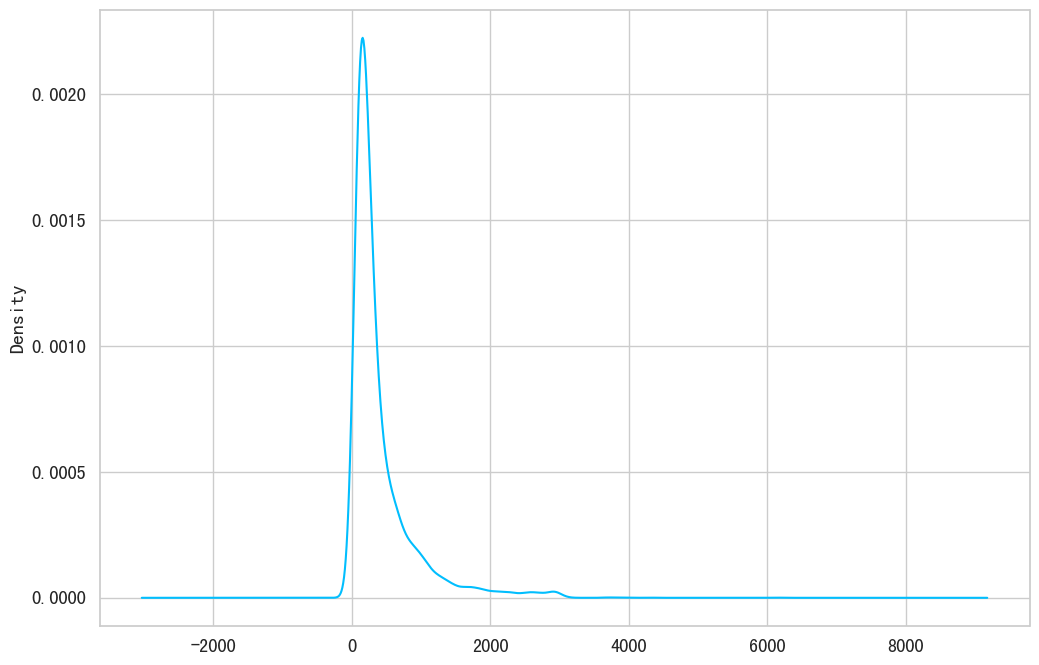

In [15]:
plt.rcParams['axes.unicode_minus'] = False
train['文本长度'].plot(kind='kde')

In [16]:
PRE_TRAINED_MODEL_NAME = 'bert-base-chinese'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [17]:
tokenizer

BertTokenizer(name_or_path='bert-base-chinese', vocab_size=21128, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

### 使用BertTokenizer分词

In [20]:
encoding=tokenizer.encode_plus(
    #返回所有编码特征
    sample_txt,
    max_length=128,
    add_special_tokens=True,# [CLS]和[SEP]
    return_token_type_ids=True, 
    pad_to_max_length=True, 
    return_attention_mask=True,
    return_tensors='pt',# Pytorch tensor张量

)
encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [21]:
encoding

{'input_ids': tensor([[ 101,  791, 1921, 3193,  677,  130, 4157, 1288, 6629, 2414, 8024, 2769,
         1762, 2110,  739, 7564, 6378, 5298, 3563, 1798, 4638,  886, 4500,  119,
          102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0,

In [22]:
MAX_LEN = 128

### 构建数据集

In [23]:
class EnterpriseDataset(Dataset):
    def __init__(self,texts,labels,tokenizer,max_len):
        self.texts=texts
        self.labels=labels
        self.tokenizer=tokenizer
        self.max_len=max_len
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self,item):
        """
        item 为数据索引，迭代取第item条数据
        """
        text=str(self.texts[item])
        label=self.labels[item]
        
        encoding=self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        #print(encoding['input_ids'])
        return {
            'texts':text,
            'input_ids':encoding['input_ids'].flatten(),
            'attention_mask':encoding['attention_mask'].flatten(),
            'labels':torch.tensor(label,dtype=torch.long)
        }

### 划分数据集并创建生成器

In [24]:
df_train, df_test = train_test_split(train, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_train.shape, df_val.shape, df_test.shape

((6631, 3), (368, 3), (369, 3))

In [25]:
def create_data_loader(df,tokenizer,max_len,batch_size):
    ds=EnterpriseDataset(
        texts=df['留言内容'].values,
        labels=df['一级标签'].values,
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
    )

In [26]:
BATCH_SIZE = 24

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

### loader展示

In [27]:
next(iter(train_data_loader))

{'texts': ['在M市入了医保到A市爱尔眼科医院做手术后回去报不了？ 我是以个患眼科病比较罕见的别人，到全省多家大医院做了检查都没有找到比较好的治疗方案，但是经过朋友介绍到A市爱尔眼科医院找到了全国比较有名的教授，也找到了比较好的治疗方案，但是到M市医保局一问，A市爱尔眼科的医药费报不了。我不知道为什么，我问了下A市爱尔，他们那里，E市，G市，L市等地的都可以报，只有我们M市的不可以报，我不知道什么原因，我入了那么多年的医保为什么到一家那么大的医院做手术不能报销，而且整个西地省只有M市不能报销，所以想请M市医保局的领导帮我们做做好事别让我们正常的有医保的没有地方可以报。谢谢！',
  'B市高中学籍挂靠招生骗局何时休 我小孩今年初中毕业，报考B市十八中美术生，考试成绩没有达到学校录取线，我老婆的同时介绍说，只要花点钱找人可以录取并推荐了联系人王坤（社会无业人员，，株化生活区1区20栋305），我们根据王坤的要求第一时间给了他4.5万元，他承诺一周之内答复。一周后，我们联系他，他说等补录。补录时间过去了也没有录取消息，我们再次联系他，他说已经录取了，叫我们吃个定心丸，八月初直接带我们去学校报到。八月份到了，他又说现在放暑假，没人上班，等开学再去报到。等到开学8月29日，他来电话说带我们先去潇楚实验中学（民办学校）报到，办理注册手续，学籍暂时挂在民办学校，然后再去十八中报到，一学期后学籍再转让十八中。此时，我彻底放弃幻想，这是完全是个骗局。因为错失公办学校录取时间，本来我小孩被B市工业学校普职融通班录取的，结果选择放弃，只能赶紧联系外地比较好的民办学校，给小孩办理入学手续，让他安心学习。安排好小孩之后，我第一时间来到十八中，找到杨电波校长反应情况。杨校长听完我的反应后，说的第一句话竟然是：“以前听说有人花多少进我们学校，我不信，今天听你这么一说，我相信了，我感到很自豪。”我问他学校有没有这种学籍挂靠在民办学校在18中寄读的学生，他说有少数特殊关系的几个学生存在这种情况。尔后敷衍几句，把我打发走了。接下来我向片区督导林喜元和B市驻教育局纪委反应，均没有什么处理结果。据我侧面了解，B市内公办高中几乎都存在这种学籍挂靠寄读生，这说明B市存在一个利用学籍挂靠实施虚假招生承诺的诈骗团伙，王坤自己介绍每年通过他们这种方式解决很多小孩的学习问题。根据西地省中小学学籍管理制度和

In [28]:
data_input = next(iter(train_data_loader))
data_input.keys()

dict_keys(['texts', 'input_ids', 'attention_mask', 'labels'])

In [29]:
print(data_input['input_ids'].shape)
print(data_input['attention_mask'].shape)
print(data_input['labels'].shape)

torch.Size([24, 128])
torch.Size([24, 128])
torch.Size([24])


### 基于BERT的政务文本分类

In [30]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [31]:
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(21128, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [32]:
last_hidden_state, pooled_output = bert_model(
    input_ids=encoding['input_ids'], 
    attention_mask=encoding['attention_mask'],
    return_dict = False
)

In [33]:
last_hidden_state # 每个token的向量表示

tensor([[[ 0.8880,  0.1987,  1.3610,  ..., -0.5096,  0.3742, -0.2368],
         [-0.0747,  0.3148,  1.4699,  ..., -1.0238, -0.0518, -0.0557],
         [ 1.0133, -0.6058,  1.0152,  ...,  0.3536,  1.1091, -0.1179],
         ...,
         [-0.0071, -0.1262, -0.0782,  ...,  0.3025, -0.2619, -0.1004],
         [-0.0977, -0.2776, -0.1804,  ...,  0.3308, -0.2601, -0.1434],
         [-0.1423, -0.3003, -0.1527,  ...,  0.3480, -0.2467, -0.1152]]],
       grad_fn=<NativeLayerNormBackward0>)

In [34]:
pooled_output

tensor([[ 0.9999,  0.9998,  0.9989,  0.9629,  0.3075, -0.1866, -0.9904,  0.8628,
          0.9710, -0.9993,  1.0000,  1.0000,  0.9312, -0.9394,  0.9998, -0.9999,
          0.0417,  0.9999,  0.9458,  0.3190,  1.0000, -1.0000, -0.9062, -0.9048,
          0.1764,  0.9983,  0.9346, -0.8122, -0.9999,  0.9996,  0.7879,  0.9999,
          0.8475, -1.0000, -1.0000,  0.9413, -0.8260,  0.9889, -0.4976, -0.9857,
         -0.9955, -0.9580,  0.5833, -0.9996, -0.8932,  0.8563, -1.0000, -0.9999,
          0.9719,  0.9999, -0.7430, -0.9993,  0.9756, -0.9754,  0.2991,  0.8933,
         -0.9991,  0.9987,  1.0000,  0.4156,  0.9992, -0.9452, -0.8020, -0.9999,
          1.0000, -0.9964, -0.9900,  0.4365,  1.0000,  1.0000, -0.9400,  0.8794,
          1.0000,  0.9105, -0.6616,  1.0000, -0.9999,  0.6892, -1.0000, -0.9817,
          1.0000,  0.9957, -0.8844, -0.8248, -0.9921, -0.9999, -0.9998,  1.0000,
          0.5228,  0.1297,  0.9932, -0.9999, -1.0000,  0.9993, -0.9996, -0.9948,
         -0.9561,  0.9996, -

In [35]:
print('last_hidden_state:', last_hidden_state.shape)
print('pooled_output:',pooled_output.shape)
print('bert_model.config.hidden_size:',bert_model.config.hidden_size)

last_hidden_state: torch.Size([1, 128, 768])
pooled_output: torch.Size([1, 768])
bert_model.config.hidden_size: 768


In [36]:
class GovernmenttextsClassifier(nn.Module):
    def __init__(self, n_classes):
        super(GovernmenttextsClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict = False
        )
        output = self.drop(pooled_output) # dropout
        return self.out(output)

In [37]:
class_names=[0,1,2,3,4,5,6]

In [38]:
model = GovernmenttextsClassifier(len(class_names))
model = model.to(device)

In [39]:
data_input

{'texts': ['在M市入了医保到A市爱尔眼科医院做手术后回去报不了？ 我是以个患眼科病比较罕见的别人，到全省多家大医院做了检查都没有找到比较好的治疗方案，但是经过朋友介绍到A市爱尔眼科医院找到了全国比较有名的教授，也找到了比较好的治疗方案，但是到M市医保局一问，A市爱尔眼科的医药费报不了。我不知道为什么，我问了下A市爱尔，他们那里，E市，G市，L市等地的都可以报，只有我们M市的不可以报，我不知道什么原因，我入了那么多年的医保为什么到一家那么大的医院做手术不能报销，而且整个西地省只有M市不能报销，所以想请M市医保局的领导帮我们做做好事别让我们正常的有医保的没有地方可以报。谢谢！',
  'B市高中学籍挂靠招生骗局何时休 我小孩今年初中毕业，报考B市十八中美术生，考试成绩没有达到学校录取线，我老婆的同时介绍说，只要花点钱找人可以录取并推荐了联系人王坤（社会无业人员，，株化生活区1区20栋305），我们根据王坤的要求第一时间给了他4.5万元，他承诺一周之内答复。一周后，我们联系他，他说等补录。补录时间过去了也没有录取消息，我们再次联系他，他说已经录取了，叫我们吃个定心丸，八月初直接带我们去学校报到。八月份到了，他又说现在放暑假，没人上班，等开学再去报到。等到开学8月29日，他来电话说带我们先去潇楚实验中学（民办学校）报到，办理注册手续，学籍暂时挂在民办学校，然后再去十八中报到，一学期后学籍再转让十八中。此时，我彻底放弃幻想，这是完全是个骗局。因为错失公办学校录取时间，本来我小孩被B市工业学校普职融通班录取的，结果选择放弃，只能赶紧联系外地比较好的民办学校，给小孩办理入学手续，让他安心学习。安排好小孩之后，我第一时间来到十八中，找到杨电波校长反应情况。杨校长听完我的反应后，说的第一句话竟然是：“以前听说有人花多少进我们学校，我不信，今天听你这么一说，我相信了，我感到很自豪。”我问他学校有没有这种学籍挂靠在民办学校在18中寄读的学生，他说有少数特殊关系的几个学生存在这种情况。尔后敷衍几句，把我打发走了。接下来我向片区督导林喜元和B市驻教育局纪委反应，均没有什么处理结果。据我侧面了解，B市内公办高中几乎都存在这种学籍挂靠寄读生，这说明B市存在一个利用学籍挂靠实施虚假招生承诺的诈骗团伙，王坤自己介绍每年通过他们这种方式解决很多小孩的学习问题。根据西地省中小学学籍管理制度和

In [40]:
input_ids = data_input['input_ids'].to(device)
attention_mask = data_input['attention_mask'].to(device)

print(input_ids.shape) 
print(attention_mask.shape) 

torch.Size([24, 128])
torch.Size([24, 128])


In [41]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.1603, 0.2347, 0.0809, 0.1176, 0.0812, 0.1890, 0.1363],
        [0.2258, 0.1857, 0.0230, 0.2175, 0.1468, 0.0750, 0.1262],
        [0.2129, 0.1472, 0.0950, 0.1246, 0.0495, 0.2416, 0.1293],
        [0.2118, 0.1294, 0.1208, 0.0895, 0.0881, 0.2851, 0.0753],
        [0.1092, 0.3769, 0.0520, 0.1300, 0.0521, 0.2046, 0.0751],
        [0.1729, 0.1585, 0.0741, 0.1379, 0.0851, 0.2666, 0.1049],
        [0.1171, 0.1741, 0.0750, 0.1382, 0.0710, 0.2630, 0.1615],
        [0.2179, 0.1397, 0.1433, 0.2440, 0.0443, 0.1100, 0.1009],
        [0.2308, 0.1461, 0.1143, 0.1324, 0.0787, 0.2487, 0.0490],
        [0.1859, 0.2240, 0.1183, 0.0750, 0.0606, 0.2599, 0.0763],
        [0.1494, 0.2444, 0.0743, 0.1374, 0.0957, 0.2136, 0.0853],
        [0.1181, 0.3622, 0.0683, 0.0926, 0.0854, 0.1946, 0.0788],
        [0.2226, 0.1018, 0.0872, 0.1708, 0.0704, 0.2549, 0.0923],
        [0.1016, 0.1945, 0.0793, 0.1984, 0.0830, 0.2172, 0.1261],
        [0.2584, 0.2256, 0.1380, 0.1271, 0.0493, 0.0990, 0.1026],
        [0

### 模型训练

In [42]:
model

GovernmenttextsClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, ele

In [43]:
EPOCHS = 10 # 训练轮数

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0, #没有热身步骤
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [44]:
def train_epoch(
  model, #训练的模型
  data_loader, #数据加载器
  loss_fn, #损失函数
  optimizer, #优化器
  device, #设备
  scheduler, #学习率调度器
  n_examples #样本数
):
    model = model.train()
    
    losses = [] #储存每个batch的损失
    correct_predictions = 0 #记录正确预测的数量
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["labels"].to(device)
        
        #梯度归零
        model.zero_grad()
        
        #前向传播
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        
        # 计算正确预测数量和损失
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        #反向传播和优化
        loss.backward()
        
        #梯度裁剪
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        #参数更新
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    #计算平均损失
    mean_loss = torch.tensor(losses, dtype=torch.float32).mean().item()
    accuracy = correct_predictions.to(dtype=torch.float32) / n_examples
    return accuracy, mean_loss

In [45]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval() # 验证预测模式

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    mean_loss = torch.tensor(losses, dtype=torch.float32).mean().item()
    accuracy = correct_predictions.to(dtype=torch.float32) / n_examples
    return accuracy, mean_loss

In [46]:
history = defaultdict(list) # 记录10轮loss和acc
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc


Epoch 1/10
----------
Train loss 0.5477223992347717 accuracy 0.8202382922172546
Val   loss 0.2408953607082367 accuracy 0.9320651888847351

Epoch 2/10
----------
Train loss 0.22171607613563538 accuracy 0.9362087249755859
Val   loss 0.29869118332862854 accuracy 0.9320651888847351

Epoch 3/10
----------
Train loss 0.11795967817306519 accuracy 0.9684813618659973
Val   loss 0.33461183309555054 accuracy 0.9239130616188049

Epoch 4/10
----------
Train loss 0.06106065586209297 accuracy 0.9853717684745789
Val   loss 0.4449233412742615 accuracy 0.9103260636329651

Epoch 5/10
----------
Train loss 0.03507678583264351 accuracy 0.9923088550567627
Val   loss 0.35073503851890564 accuracy 0.9239130616188049

Epoch 6/10
----------
Train loss 0.019565250724554062 accuracy 0.9956266283988953
Val   loss 0.40275198221206665 accuracy 0.9320651888847351

Epoch 7/10
----------
Train loss 0.013087824918329716 accuracy 0.9971346855163574
Val   loss 0.36894071102142334 accuracy 0.9375

Epoch 8/10
----------
Trai

### 将张量移到cpu上

In [47]:
history

defaultdict(list,
            {'train_acc': [tensor(0.8202, device='mps:0'),
              tensor(0.9362, device='mps:0'),
              tensor(0.9685, device='mps:0'),
              tensor(0.9854, device='mps:0'),
              tensor(0.9923, device='mps:0'),
              tensor(0.9956, device='mps:0'),
              tensor(0.9971, device='mps:0'),
              tensor(0.9986, device='mps:0'),
              tensor(0.9991, device='mps:0'),
              tensor(0.9992, device='mps:0')],
             'train_loss': [0.5477223992347717,
              0.22171607613563538,
              0.11795967817306519,
              0.06106065586209297,
              0.03507678583264351,
              0.019565250724554062,
              0.013087824918329716,
              0.006985536776483059,
              0.00571907265111804,
              0.00462272809818387],
             'val_acc': [tensor(0.9321, device='mps:0'),
              tensor(0.9321, device='mps:0'),
              tensor(0.9239, device='m

In [48]:
# 将数据从 MPS 设备上移动到 CPU 上
train_acc_cpu = [tensor.cpu().numpy() for tensor in history['train_acc']]
val_acc_cpu = [tensor.cpu().numpy() for tensor in history['val_acc']]

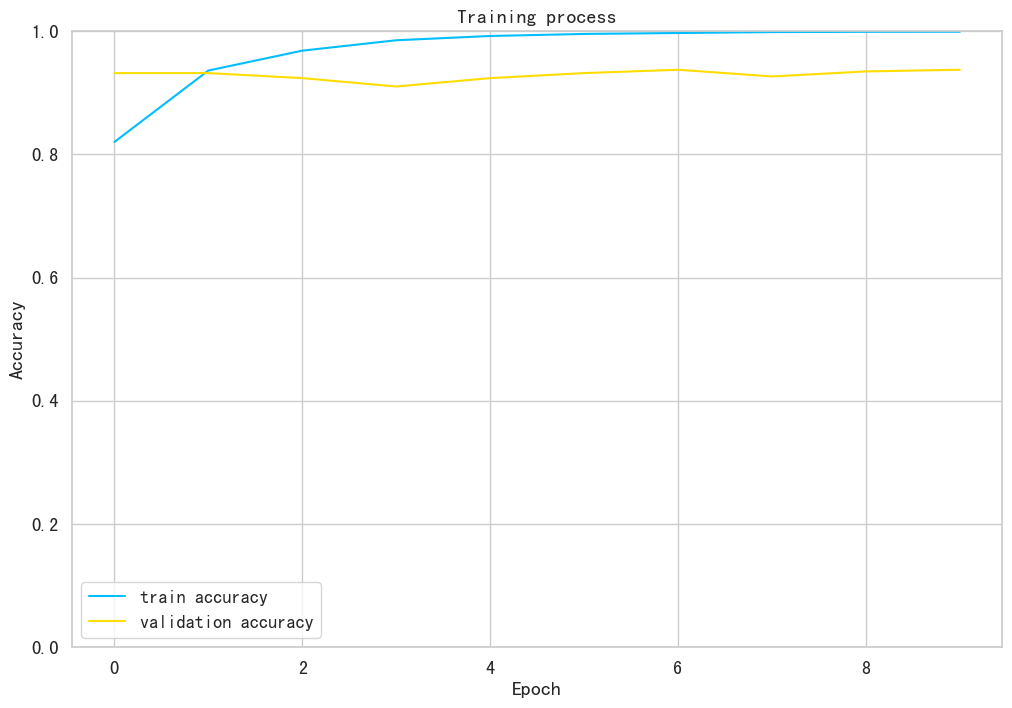

In [49]:
plt.plot(train_acc_cpu, label='train accuracy')
plt.plot(val_acc_cpu, label='validation accuracy')

plt.title('Training process')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [50]:
model = GovernmenttextsClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

### 模型评估

In [51]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.913279116153717

In [52]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():#预测时不需要更新梯度
        for d in data_loader:
            texts = d["texts"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)
            
    # 将所有的预测值、预测概率和真实值堆叠成张量，并将其转移到cpu上
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, prediction_probs, real_values

In [53]:
# y_texts: 真实文本   
# y_pred: 预测类别
# y_pred_probs: 预测概率
# y_test: 真实标签
y_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [54]:
#使用classification_report()生成分类报告
report = classification_report(y_test, y_pred, target_names=[str(label) for label in class_names], output_dict=True)
print(classification_report(y_test, y_pred, target_names=[str(label) for label in class_names]))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        78
           1       0.92      0.96      0.94        25
           2       0.83      0.95      0.89        21
           3       0.94      0.88      0.91        73
           4       0.90      0.99      0.94        77
           5       0.92      0.84      0.88        58
           6       0.94      0.92      0.93        37

    accuracy                           0.91       369
   macro avg       0.91      0.92      0.91       369
weighted avg       0.91      0.91      0.91       369



### 各类别各评估指标可视化

In [56]:
# 针对'一级标签'映射的反映射
reverse_mapping_dict = {index: value for value, index in mapping_dict.items()}

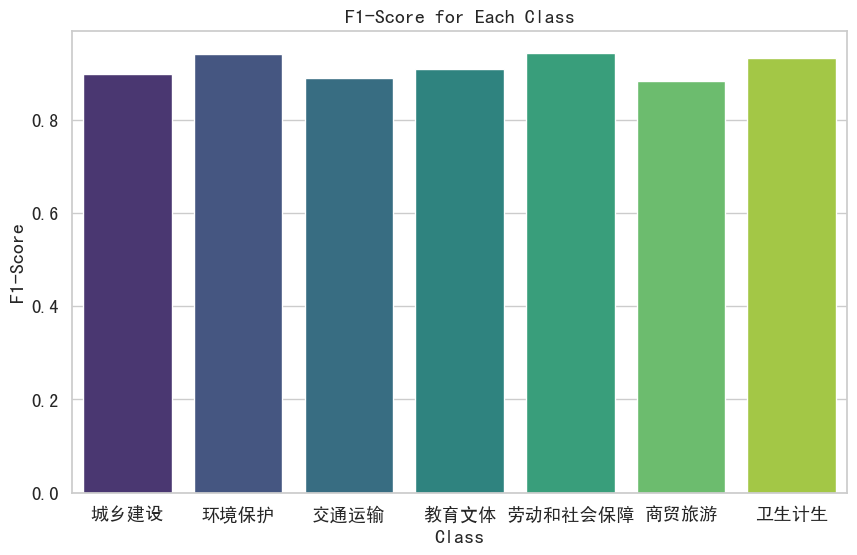

In [57]:
# 从报告中提取f1-score
f1_scores = {str(label): report[str(label)]['f1-score'] for label in class_names}
x_labels = []
for i in list(f1_scores.keys()):
    x_labels.append(reverse_mapping_dict[int(i)])
# 可视化f1-score
plt.figure(figsize=(10, 6))
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为中文宋体
plt.rcParams['axes.unicode_minus'] = False
sns.barplot(x=x_labels, y=list(f1_scores.values()), palette="viridis")
plt.title('F1-Score for Each Class')
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.show()

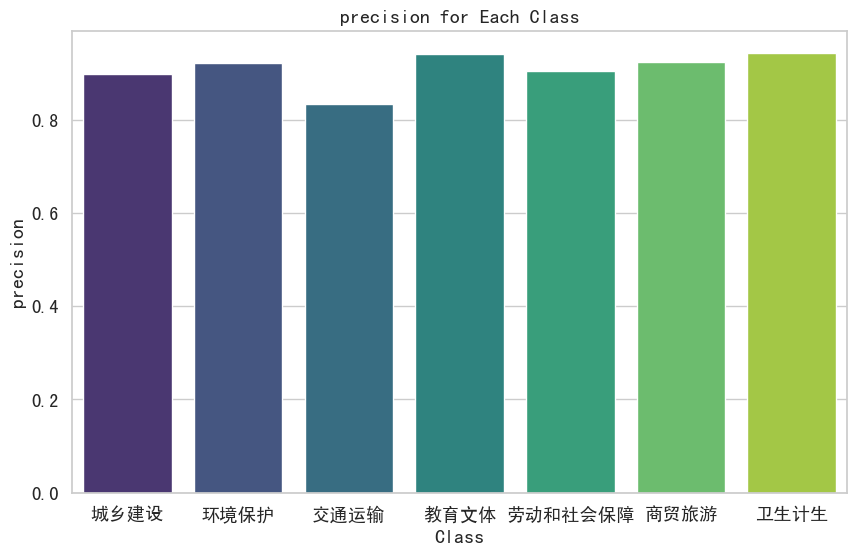

In [58]:
# 从报告中提取precision
precisions = {str(label): report[str(label)]['precision'] for label in class_names}
x_labels = []
for i in list(precisions.keys()):
    x_labels.append(reverse_mapping_dict[int(i)])
# 可视化precision
plt.figure(figsize=(10, 6))
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为中文宋体
plt.rcParams['axes.unicode_minus'] = False
sns.barplot(x=x_labels, y=list(precisions.values()), palette="viridis")
plt.title('precision for Each Class')
plt.xlabel('Class')
plt.ylabel('precision')
plt.show()

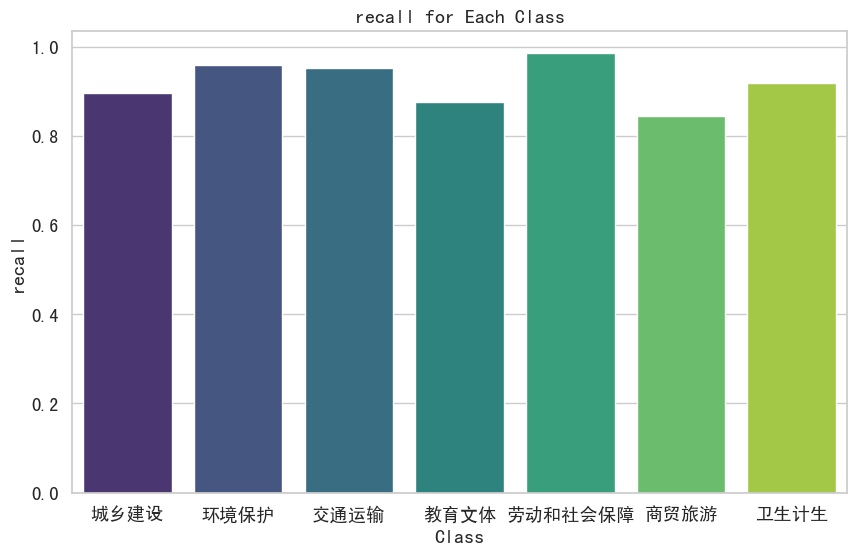

In [59]:
# 从报告中提取recall
recalls = {str(label): report[str(label)]['recall'] for label in class_names}
x_labels = []
for i in list(recalls.keys()):
    x_labels.append(reverse_mapping_dict[int(i)])
# 可视化f1-score
plt.figure(figsize=(10, 6))
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为中文宋体
plt.rcParams['axes.unicode_minus'] = False
sns.barplot(x=x_labels, y=list(recalls.values()), palette="viridis")
plt.title('recall for Each Class')
plt.xlabel('Class')
plt.ylabel('recall')
plt.show()

### 绘制混淆矩阵

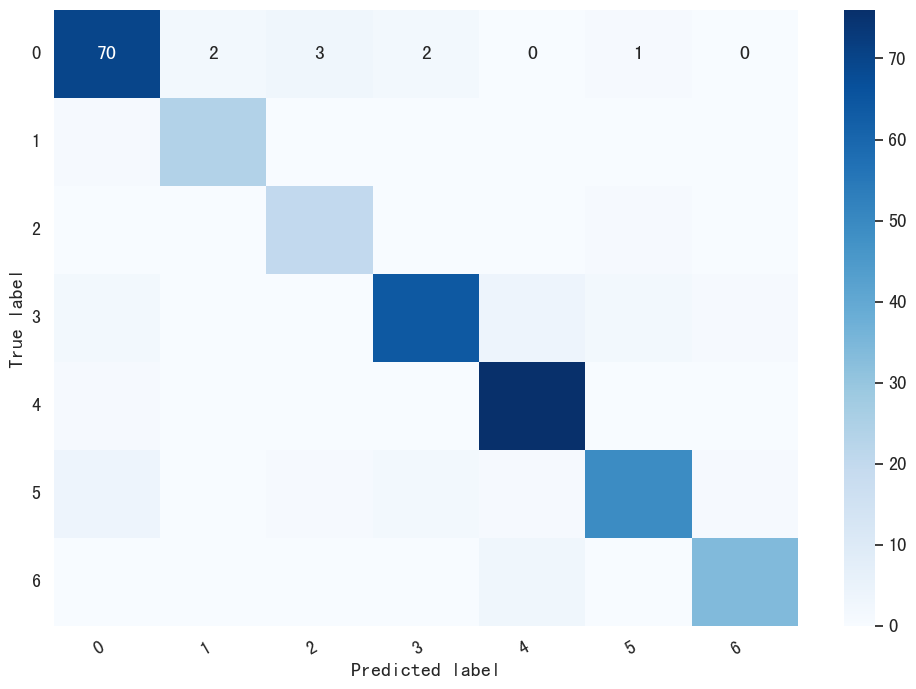

In [60]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label');


cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [61]:
# 针对'一级标签'映射的反映射
reverse_mapping_dict = {index: value for value, index in mapping_dict.items()}

In [62]:
idx = 2
sample_text = y_texts[idx]
pred_label = y_pred[idx]
true_label = y_test[idx]
#每个类别的概率
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})
print("\n".join(wrap(sample_text)))
print(f'预测的一级标签: {reverse_mapping_dict[class_names[pred_label]]}')
print(f'真实的一级标签: {reverse_mapping_dict[class_names[true_label]]}')

西地省工人技术等级何时开考？ 胡厅长：您好！我是J市林业基层工作人员，木材检验技术工人，去年工龄20年，去年本应该参加考试由中级工升为高级工
，不知道什么原因省厅没有开考，今年又是快10月份了，还没有消息。基层人员本来工资就低，升级还是能提高部分工资，并且能及时再考试升技师。如2年
不开考，那我们就一辈子耽误2年，请厅长您关心下此事，争取今年开考，关心我们基层人员，不胜感激您！
预测的一级标签: 教育文体
真实的一级标签: 教育文体


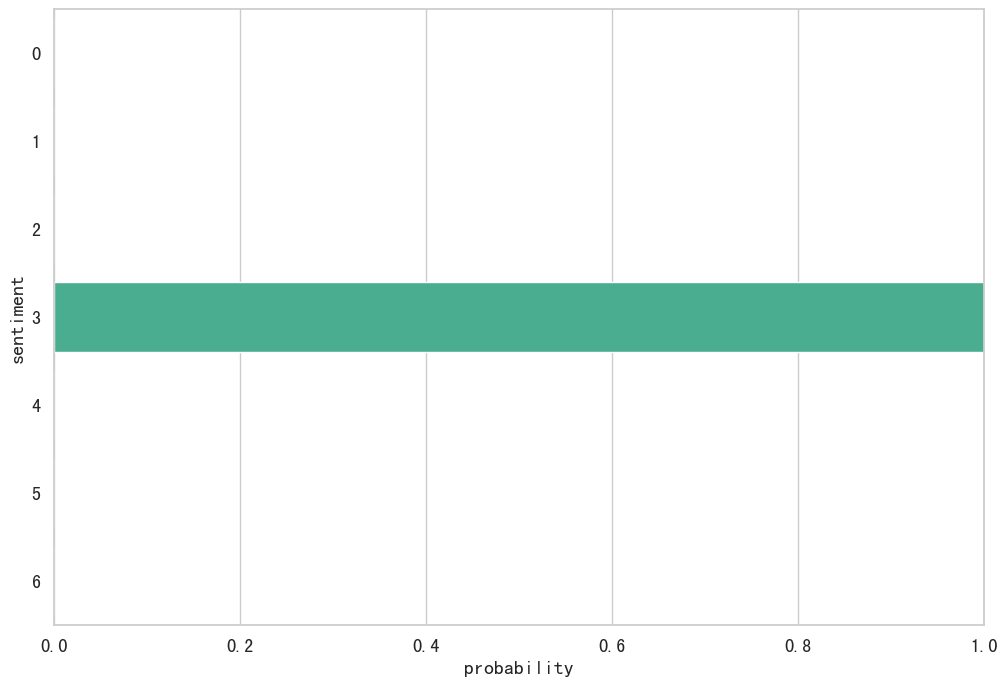

In [63]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### 新输入测试

In [64]:
new_text = "读书真累"

encoded_text = tokenizer.encode_plus(
  new_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'留言内容: {new_text}')
print(f'一级标签: {reverse_mapping_dict[class_names[prediction]]}')

留言内容: 读书真累
一级标签: 教育文体
